In [4]:
#Import libraries
import os
import pydicom
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage.filters as filters

In [10]:

# Load data and masks as dicom files
data_dir = '../../../data'                   #Please change the path accordingly before make any changes
normalNames = data_dir + '/GoodData_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

normal_namelist = []
with open(normalNames) as f:
    content = f.readlines()
    normal_namelist = [x.strip() for x in content] 
    

sample = pydicom.read_file(os.path.join(img_dir, normal_namelist[0])).pixel_array
mask = pydicom.read_file(os.path.join(msk_dir, normal_namelist[0].split('.')[0] + '.result.dcm')).pixel_array

In [11]:
def to3dpatches (origin, labelImg, depth = 32, size = 32, complete = False, toBoxes = True, onlyValid = False):
    originStacks = []
    labelStacks = []
    origin_boxes = []
    label_boxes = []
    
    if complete:                                  #Directly output stacks if complete is set to true
        n_stack =int(labelImg.shape[0]/depth)
        output_start_index = int((labelImg.shape[0]%depth)/2)
        output_start_index = output_start_index if output_start_index > 0 else 0

        for i in range(n_stack):
            start_index = output_start_index + i * depth
            originStacks.append(origin[start_index:start_index+depth, ...]) 
            labelStacks.append(labelImg[start_index:start_index+depth, ...])   
    
    else:
        check_zeros = []
        for i in range(labelImg.shape[0]):
            check_zeros.append(np.any(np.asarray(labelImg[i]))) #check every slice along z axis (depth)
        
        non_zero_index = np.nonzero(check_zeros)
        try:
            non_zero_range = [np.amin(non_zero_index), np.amax(non_zero_index)]
        except ValueError as err:
            print("Very likely to contain zero information in the labelled data")
            return err
        #print(non_zero_range)
        n_object_slice = non_zero_range[1] - non_zero_range[0]  
        n_stack = int(n_object_slice/depth) + 1
    #print(non_zero_range)
        output_start_index = int(non_zero_range[0]+n_object_slice/2 - n_stack*depth/2)
        output_start_index = output_start_index if output_start_index > 0 else 0
        
    
        for i in range(n_stack):
            start_index = output_start_index + i * depth
            originStacks.append(origin[start_index:start_index+depth, ...])   # Cut middle stackes
            labelStacks.append(labelImg[start_index:start_index+depth, ...])   # Cut middle stackes
        
        if(origin.shape[1]%size != 0):
            print("Err: the images cannot be divided to boxes!")
            return -1
    if toBoxes:
        n_alongaxis = int(origin.shape[1]/size)    #only consider x = y for our project
        for origin_stack, label_stack in zip(originStacks, labelStacks):
            for i in range(n_alongaxis):
                for j in range(n_alongaxis):
                    origin_box = origin_stack[:,i*size:(i+1)*size,j*size:(j+1)*size]
                    lable_box = label_stack[:,i*size:(i+1)*size,j*size:(j+1)*size]
                    if onlyValid:                                 #Only out put boxes with aneurysm
                        if np.any(lable_box):
                            origin_boxes.append(origin_box)
                            label_boxes.append(lable_box)
                    else:
                        origin_boxes.append(origin_box)
                        label_boxes.append(lable_box)

        return len(origin_boxes), origin_boxes, label_boxes
    else:
        return n_stack, originStacks, labelStacks
    
    


In [60]:
number, data_boxes, mask_boxes = to3dpatches(sample, mask, depth=64, size=64, toBoxes = True, complete=True, onlyValid=False)
print(number, len(data_boxes), len(mask_boxes), data_boxes[0].shape)


48 48 48 (64, 64, 64)


In [61]:
j = 0 
k =0
box_along_x = []
x_strips = []
y_strips = []
for i in range(3):
    for j in range(4):
        for k in range(4):
            #strip = np.concatenate([mask_boxes[int(4*j+k*2)], mask_boxes[int(4*j+k*2+1)]])
            box_along_x.append(mask_boxes[4*j+k])
        print("box:", box_along_x[0].shape)
        x_strip=np.concatenate(box_along_x, axis=2)
        box_along_x = []
        x_strips.append(x_strip)
        print("x_strip:", x_strips[0].shape)
    y_strip = np.concatenate(x_strips, axis=1)
    x_strips= []
    y_strips.append(y_strip)
    print("Y_strip:", y_strips[0].shape)
whole = np.concatenate(y_strips, axis=0)
print(whole.shape)
   

box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
Y_strip: (64, 256, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
Y_strip: (64, 256, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
box: (64, 64, 64)
x_strip: (64, 64, 256)
Y_strip: (64, 256, 256)
(192, 256, 256)


In [62]:
 
number, data_boxes, mask_boxes = to3dpatches(sample, mask, depth=64, size=64, toBoxes = False, complete=True, onlyValid=False)
stack = np.concatenate(mask_boxes, axis =0)
print(stack.shape)
np.array_equal(whole, stack)

            

(192, 256, 256)


False

In [45]:
def filter_image (textfile, img_dir, msk_dir, size = (220, 256, 256), mask_threshold = 50000000):
    with open(textfile) as f:
        content = f.readlines()
    normal_namelist = [x.strip() for x in content]

    #Get good image names
    files = os.listdir(img_dir)
    img_name_list = []
    for filename in files:
        if filename in normal_namelist:
            img_name_list.append(filename)
    #print(img_name_list, normal_namelist)
    #Get corresponding masks names, delete from both name lists if mask does not exists
    msk_name_list = []
    invalid_img_list = []
    total_mask_pixel = np.array([])
    for filename in img_name_list:   #correspond images loaded
        img_namesplt = filename.split('.')
        msk_name = img_namesplt[0]+'.result.dcm'
        #print(msk_name)
        try:
            mask = pydicom.read_file(os.path.join(msk_dir, msk_name))
        except:
            #print(filename + " does not have a result dicom file in the mask folder! will delete that from image lists")
            invalid_img_list.append(filename)
        else:
            #total_mask_pixel = np.append (total_mask_pixel, mask.pixel_array.sum())
            #print(mask[0].pixel_array.sum(), mask[1])
            print(mask.pixel_array.shape)
            if mask.pixel_array.shape == size and mask.pixel_array.sum() < mask_threshold:           
                msk_name_list.append(msk_name)
            else: 
                invalid_img_list.append(filename)
            
 #   print(mask, mask.pixel_array.sum())
    for filename in invalid_img_list:
        img_name_list.remove(filename) 
    plt.hist(total_mask_pixel)

    return img_name_list, msk_name_list

(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)
(220, 256, 256)


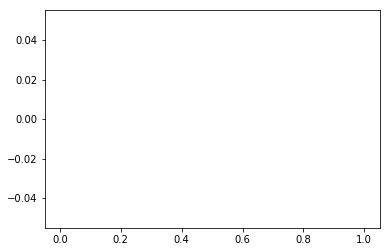

In [3]:
# Load data and masks as dicom files
data_dir = '../../data'                   #Please change the path accordingly before make any changes
normalnames = data_dir + '/normal_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

image_name_list, mask_name_list = filter_image(normalnames, img_dir, msk_dir)
#print(image_name_list)


In [29]:
import scipy.ndimage.filters as filters

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
image_dic_list = [pydicom.read_file(os.path.join(img_dir, filename)) for filename in image_name_list ]
'''
Visulize 3d images
@param: image - input 3d image
        threshold - thresholding the 3d image
'''
def plot_3d(image1, image2 = None, threshold=-300, threshold2 = 0.5):
    
    verts, faces = measure.marching_cubes_classic(image1, threshold)
    
    fig = plt.figure(figsize=(20, 10))
    if image2 is None:
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(121, projection='3d')
    mesh = Poly3DCollection(verts[faces])
    ax.add_collection3d(mesh)

    ax.set_xlim(0, image1.shape[0])
    ax.set_ylim(0, image1.shape[1])
    ax.set_zlim(0, image1.shape[2])

    if image2 is not None:
        ax2 = fig.add_subplot(122, projection = '3d')
        verts2, faces2 = measure.marching_cubes_classic(image2, threshold2)
        mesh2 = Poly3DCollection(verts2[faces2])
        
        ax2.add_collection3d(mesh2)
        ax2.set_xlim(0, image2.shape[0])
        ax2.set_ylim(0, image2.shape[1])
        ax2.set_zlim(0, image2.shape[2])
        
        
    plt.show()

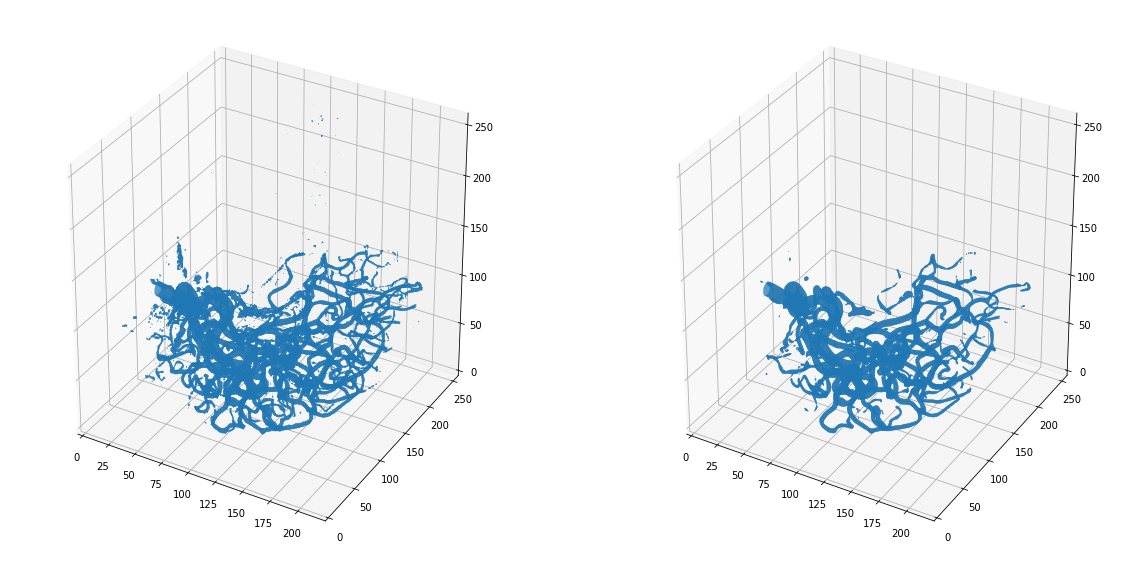

In [31]:

filtered_image = filters.gaussian_filter(image_dic_list[0].pixel_array, 1.0)
plot_3d(image_dic_list[0].pixel_array, filtered_image, threshold = 0.5, threshold2 = 0.5)
